In [7]:
#################################################
#created the 17/05/2018 14:14 by Alexis Blanchet#
#################################################
#-*- coding: utf-8 -*-
'''

'''

'''
Améliorations possibles:

'''
import warnings
warnings.filterwarnings('ignore')
#################################################
###########        Imports      #################
#################################################
import sys
import numpy as np
import pandas as pd
import scipy.stats
import plotly
import plotly.graph_objs as go
import plotly.offline as offline
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
#################################################
########### Global variables ####################
#################################################
fileX_train ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-04-30.csv'
fileX_valid ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-07.csv'
fileX_test ='/home/alexis/Bureau/Stage/ProgrammesTV/merged_2018-05-09.csv'
#################################################
########### Important functions #################
#################################################
def load(fileX):
    df = pd.read_csv(fileX)
    df = df.drop(['heure','CP','RESUME','DIFFERE','PT1','INEDIT_EN_CLAIR','OCCULTATIONMOBILE','PREMDIF','SOUSTITREDIF','TITREEMISSION'],axis=1)
    y = df['label']
    return df.drop(['label'],axis=1),y




In [2]:
X_train,y_train = load(fileX_train)
X_valid,y_valid = load(fileX_valid)
X_test,Y_test = load(fileX_test)


In [3]:
X = pd.concat([X_train,X_valid])
y = pd.concat([y_train,y_valid])
X.head()

,minutes,isinprogramme,debut,fin,TITRE,CSA,STEREO,PT3,DOLBY,CLE-GENRE,...,HD,STM,NOUVEAUTE,VOST,DOLBY51,PT2,DATE,temps depuis debut,temps avant fin,pourcentage déjà vu
0,431,1,385,505,TFou,1.0,1.0,0.0,0.0,403.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2018-04-30,46.0,74.0,0.383333
1,443,1,385,505,TFou,1.0,1.0,0.0,0.0,403.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2018-04-30,58.0,62.0,0.483333
2,455,1,385,505,TFou,1.0,1.0,0.0,0.0,403.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2018-04-30,70.0,50.0,0.583333
3,484,1,385,505,TFou,1.0,1.0,0.0,0.0,403.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2018-04-30,99.0,21.0,0.825000
4,502,1,385,505,TFou,1.0,1.0,0.0,0.0,403.0,...,1.0,1.0,0.0,0.0,0.0,0.0,2018-04-30,117.0,3.0,0.975000


In [16]:
from sklearn import preprocessing
for f in X.columns: 
    if X[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X[f].values)) 
        X[f] = lbl.transform(list(X[f].values))

for f in X_test.columns: 
    if X_test[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(X_test[f].values)) 
        X_test[f] = lbl.transform(list(X_test[f].values))


In [47]:
### XGB modeling
params = {'eta': 0.0001,
          'max_depth': 25, 
          'subsample': 0.9, 
          'colsample_bytree': 1, 
          'colsample_bylevel':1,
          'min_child_weight':1,
          'alpha':0,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': 1,
         'scale_pos_weight':0,
         'num_class' : 3,
         }
params2 = {'eta': 0.0001,
          'max_depth': 20, 
          'subsample': 0.9, 
          'colsample_bytree': 0.9, 
          'colsample_bylevel':0.9,
          'min_child_weight':0.9,
          'alpha':0.01,
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'seed': 99,
          'silent': 1,
         'scale_pos_weight':0,
          'num_class' : 3,
         }

######################################################
class Classifier(BaseEstimator):
    def __init__(self):
        pass
 
    def fit(self,X,y):
        np.random.seed(99)
        x1, x2, y1, y2 = train_test_split(X, y, test_size=0.4)
        watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
        self.clf1 = xgb.train(params, xgb.DMatrix(x1, y1), 50000,  watchlist, maximize = False,verbose_eval=5000, early_stopping_rounds=3000)
        self.clf2 = xgb.train(params2, xgb.DMatrix(x1, y1), 50000,  watchlist, maximize = False,verbose_eval=5000, early_stopping_rounds=3000)
        
       
    def predict(self, X):
        return self.clf.predict(X)
 
    def predict_proba(self, X):
        res1 = self.clf1.predict(xgb.DMatrix(X), ntree_limit=self.clf1.best_ntree_limit)
        res2 = self.clf2.predict(xgb.DMatrix(X), ntree_limit=self.clf2.best_ntree_limit)
        return np.array([[a[0]+b[0],a[1]+b[1],a[2]+b[2]] for a,b in zip(res1,res2)])



In [48]:
np.random.seed(7)
clf = Classifier()
clf.fit(X,y)

[0]	train-mlogloss:1.09853	valid-mlogloss:1.09858
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 3000 rounds.
[5000]	train-mlogloss:0.775016	valid-mlogloss:0.949717
[10000]	train-mlogloss:0.576101	valid-mlogloss:0.876713
[15000]	train-mlogloss:0.444506	valid-mlogloss:0.842176
[20000]	train-mlogloss:0.353127	valid-mlogloss:0.827095
[25000]	train-mlogloss:0.287374	valid-mlogloss:0.823072
Stopping. Best iteration:
[24062]	train-mlogloss:0.298115	valid-mlogloss:0.82296

[0]	train-mlogloss:1.09853	valid-mlogloss:1.09858
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 3000 rounds.
[5000]	train-mlogloss:0.771655	valid-mlogloss:0.948229
[10000]	train-mlogloss:0.568289	valid-mlogloss:0.871334
[15000]	train-mlogloss:0.434906	valid-mlogloss:0.833446
[20000]	train-mlogloss:0.344049	valid-mlogloss:0.817323
[25000

In [49]:
y_score = clf.predict_proba(X_test)

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
y_test = label_binarize(Y_test, classes=[0, 1, 2])
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

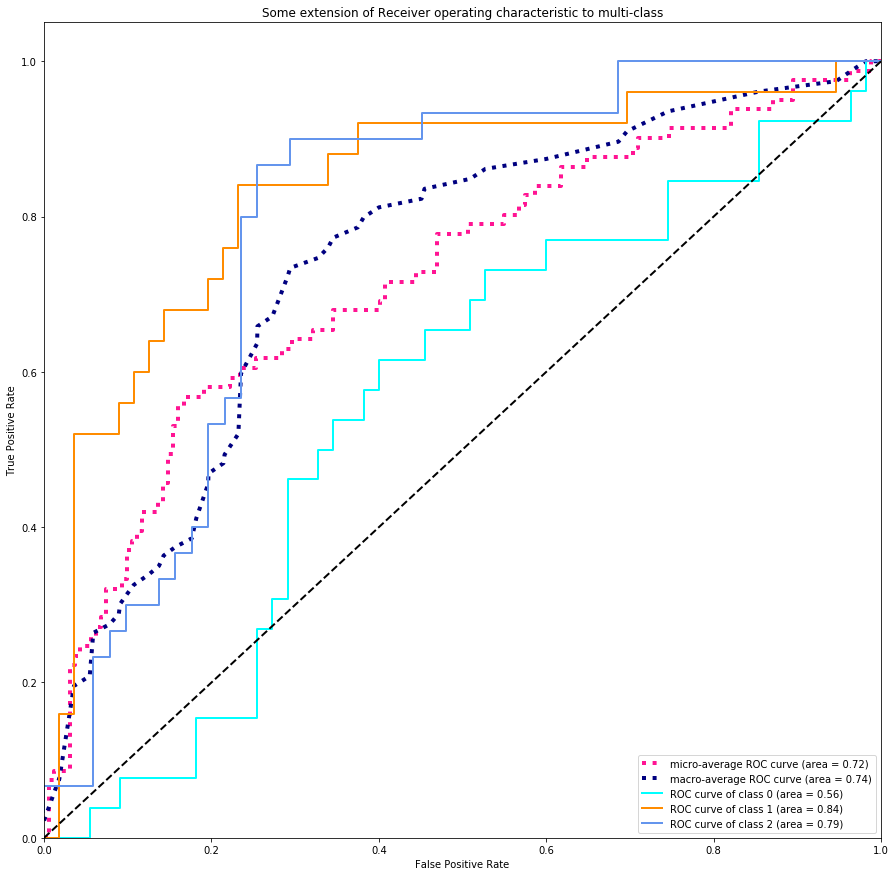

In [51]:
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(15,15))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('auc.png')
plt.show()
